**DATA PREPARATION**



*   Import Packages


In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



*   Read data from a CSV file



In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VLO.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400




*   Visualize the stock price history



Text(0, 0.5, 'Prices ($)')

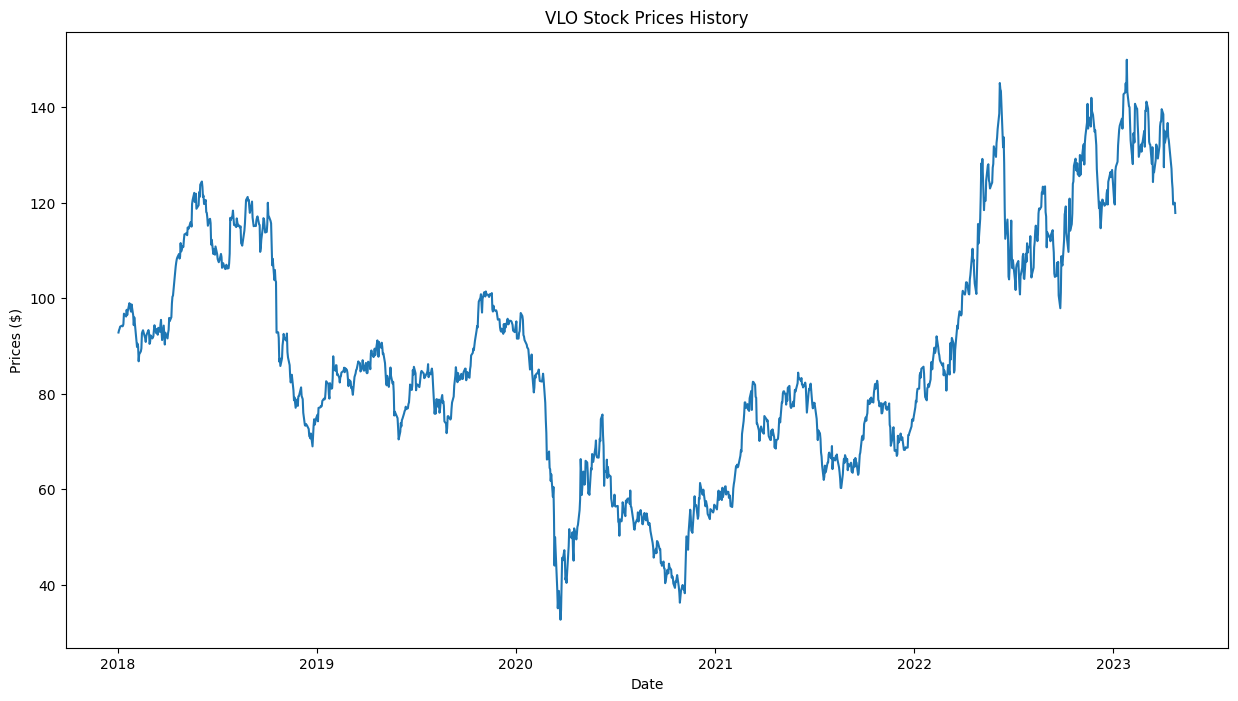

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('VLO Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**

*   Split data into train, test, and validation sets with a ratio of 7:2:1



In [5]:
close_prices = data['Close']
values = close_prices.values
train_size = int(len(close_prices) * 0.7)
test_size = int(len(close_prices) * 0.2)
val_size = len(close_prices) - train_size - test_size

window_size = 60
train_data = close_prices.iloc[:train_size]
test_data = close_prices.iloc[train_size - window_size:train_size+test_size]
val_data = close_prices.iloc[train_size+test_size-window_size:]

In [6]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  935
Test size:  267
Valate size:  135




*   Define sliding window function



In [7]:
def sliding_window(data, window_size):
  X = []
  y = []
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X), np.array(y)




*   Create train, test, and validation datasets (features & label)




In [8]:
x_train, y_train = sliding_window(train_data.values, window_size)
x_test, y_test = sliding_window(test_data.values, window_size)
x_val, y_val = sliding_window(val_data.values, window_size)

**BUILD MODEL**



*   Bayesian model with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods.



In [9]:
# Define model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, tau=1.0/100)
    beta = pm.Normal('beta', mu=0, tau=1.0/100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)

    # Likelihood
    mu = alpha + beta * x_train.mean()
    y_obs = pm.Normal('y_obs', mu=mu, tau=1.0/sigma**2, observed=y_train)

    # Inference
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

In [10]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

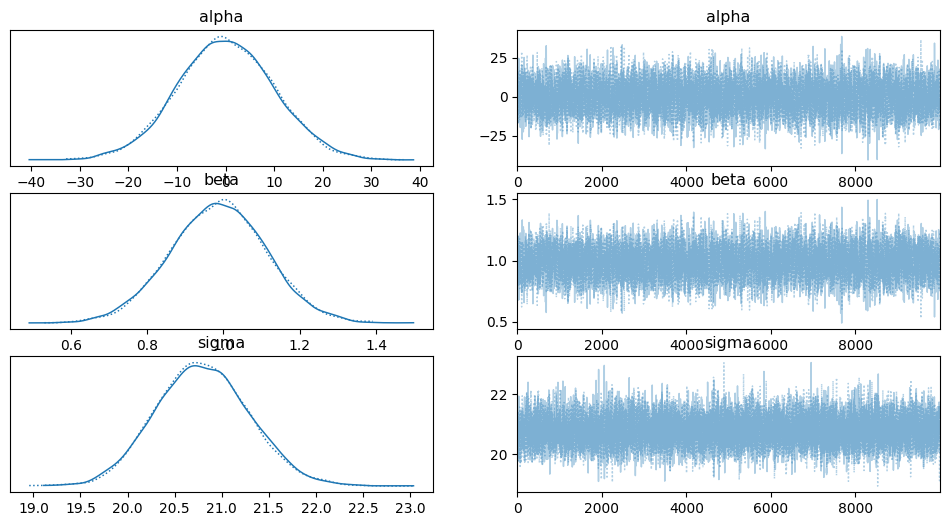

In [11]:
import arviz as az
az.plot_trace(trace)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

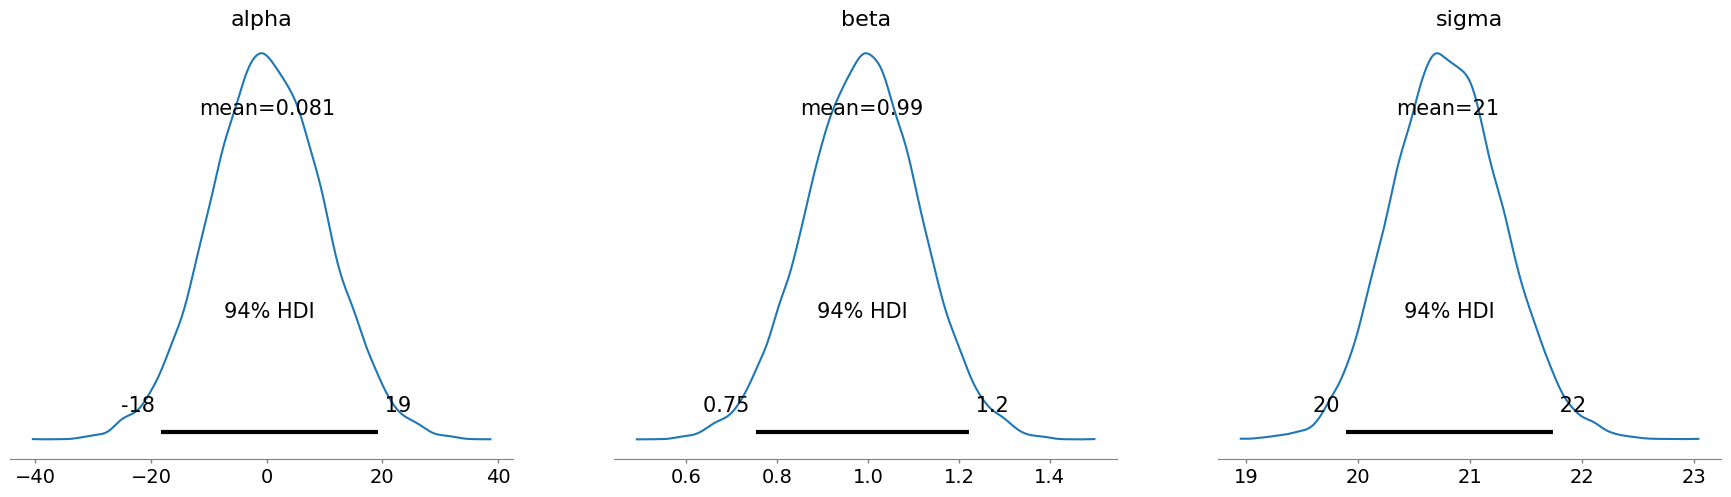

In [12]:
az.plot_posterior(trace)



*   Choose alpha, beta



In [13]:
alpha_post = trace.posterior["alpha"].mean().values
beta_post = trace.posterior["beta"].mean().values

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [14]:
# Predict on test data
stock_test_pred = []
for i in range(len(x_test)):
  pred = alpha_post + beta_post * x_test[i].mean()
  stock_test_pred.append(pred)

# Predict on validation data
stock_val_pred = []
for i in range(len(x_val)):
  pred = alpha_post + beta_post * x_val[i].mean()
  stock_val_pred.append(pred)



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [15]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((val_data.values[window_size:]- stock_val_pred) ** 2))
test_rmse = np.sqrt(np.mean((test_data.values[window_size:] - stock_test_pred) ** 2))

valid_mape = calculate_mape(val_data.values[window_size:], stock_val_pred)
test_mape = calculate_mape(test_data.values[window_size:], stock_test_pred)

valid_mda = calculate_mda(val_data.values[window_size:], stock_val_pred)
test_mda = calculate_mda(test_data.values[window_size:], stock_test_pred)

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 10.283969087266001
Testing RMSE: 12.526173299433474
Validation MAPE: 6.048394156909262
Testing MAPE: 9.919920522608694
Validation MDA: 51.49253731343284
Testing MDA: 51.127819548872175


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [16]:
num_predictions = 30

stock_pred = np.zeros(num_predictions)
last_data = val_data[-window_size:].values

for i in range(num_predictions):
    mu = alpha_post + beta_post * last_data.mean()
    stock_pred[i] = mu
    last_data = np.append(last_data[1:], mu)

print(f'Predictions for Next {num_predictions} Days: \n{stock_pred}')

Predictions for Next 30 Days: 
[130.944537   130.79244745 130.64048808 130.54853968 130.50739016
 130.48727808 130.52671379 130.46102346 130.40083272 130.36432711
 130.19381001 130.03578642 129.87697285 129.77016148 129.70107337
 129.70257152 129.66148843 129.6445692  129.59874848 129.54690983
 129.45638297 129.41898163 129.25660173 129.09253761 128.89386123
 128.71626279 128.58065173 128.51173614 128.44974754 128.38871316]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1


<ipython-input-17-6f405adbaebe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = stock_test_pred
<ipython-input-17-6f405adbaebe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Predictions'] = stock_val_pred


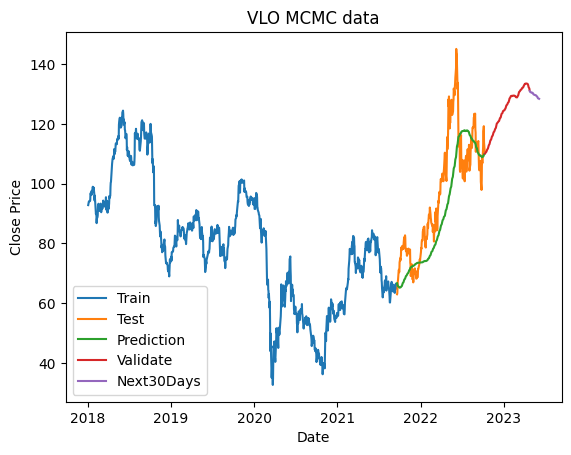

In [17]:
data = data.filter(['Close'])
train = data[:train_size]
test = data[train_size:train_size+test_size]
val = data[train_size+test_size:]
test['Predictions'] = stock_test_pred
val['Predictions'] = stock_val_pred

future_dates = pd.date_range(start=val.index[-1], periods=num_predictions+1, freq='B')[1:]
future_pred_df = pd.DataFrame({'Date': future_dates, 'Predictions': stock_pred})
future_pred_df.set_index('Date', inplace=True)

# plt.figure(figsize=(16,8))
plt.title('VLO MCMC data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.plot(val['Predictions'])
plt.plot(future_pred_df)
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Days'])
plt.show()



*   Plot 2



In [18]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_train_ind = list(range(0, train_size))
x_test_ind = list(range(train_size, train_size+test_size))
x_val_ind = list(range(train_size+test_size, len(data)))
x_pred_ind = list(range(len(data), len(data)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train_ind, y=train['Close'], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Close'], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Predictions'], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=x_val_ind, y=val['Predictions'], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=x_pred_ind, y=future_pred_df['Predictions'], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#9569BE'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'VLO MCMC data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()